In [ ]:
import tensorflow as tf
import os

_URL = 'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/edges2shoes.tar.gz'

path_to_zip = tf.keras.utils.get_file('/content/edges2shoes.tar.gz',
                                      origin=_URL,
                                      extract=True)

 886554624/2165283376 [===========>..................] - ETA: 5:37

In [ ]:
!tar -xvf /content/edges2shoes.tar.gz

In [ ]:

from os import listdir
from numpy import asarray
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed


def load_images(path, size=(256,512)):
    src_list, tar_list = list(), list()

    for filename in listdir(path):

        pixels = load_img(path + filename, target_size=size)

        pixels = img_to_array(pixels)
    
        sat_img, map_img = pixels[:, :256], pixels[:, 256:]
        src_list.append(sat_img)
        tar_list.append(map_img)
    return [asarray(src_list), asarray(tar_list)]




In [ ]:

path = '/content/drive/MyDrive/here/'

[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)


Loaded:  (20, 256, 256, 3) (20, 256, 256, 3)


In [ ]:
src_images.shape

(20, 256, 256, 3)

In [ ]:

filename = '/content/maps_256.npz'
savez_compressed(filename, src_images, tar_images)
print('Saved dataset: ', filename)

Saved dataset:  /content/maps_256.npz


Loaded:  (20, 256, 256, 3) (20, 256, 256, 3)


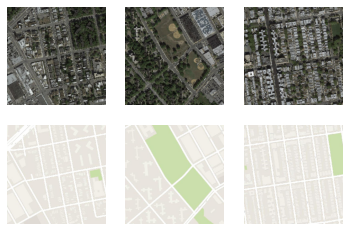

In [ ]:
from numpy import load
from matplotlib import pyplot

data = load('/content/maps_256.npz')
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)

n_samples = 3
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(src_images[i].astype('uint8'))

for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()


In [ ]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot

def define_discriminator(image_shape):

	init = RandomNormal(stddev=0.02)

	in_src_image = Input(shape=image_shape)

	in_target_image = Input(shape=image_shape)

	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)

	model = Model([in_src_image, in_target_image], patch_out)

	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model


def define_encoder_block(layer_in, n_filters, batchnorm=True):

	init = RandomNormal(stddev=0.02)

	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)

	if batchnorm:
		g = BatchNormalization()(g, training=True)

	g = LeakyReLU(alpha=0.2)(g)
	return g

def decoder_block(layer_in, skip_in, n_filters, dropout=True):

	init = RandomNormal(stddev=0.02)

	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)

	g = BatchNormalization()(g, training=True)

	if dropout:
		g = Dropout(0.5)(g, training=True)

	g = Concatenate()([g, skip_in])

	g = Activation('relu')(g)
	return g


def define_generator(image_shape=(256,256,3)):

	init = RandomNormal(stddev=0.02)

	in_image = Input(shape=image_shape)

	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)

	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)

	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)

	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)

	model = Model(in_image, out_image)
	return model

def define_gan(g_model, d_model, image_shape):

	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False

	in_src = Input(shape=image_shape)

	gen_out = g_model(in_src)

	dis_out = d_model([in_src, gen_out])

	model = Model(in_src, [dis_out, gen_out])

	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model


def load_real_samples(filename):
	data = load(filename)
	X1, X2 = data['arr_0'], data['arr_1']
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

def generate_real_samples(dataset, n_samples, patch_shape):
	trainA, trainB = dataset
	ix = randint(0, trainA.shape[0], n_samples)
	X1, X2 = trainA[ix], trainB[ix]
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

def generate_fake_samples(g_model, samples, patch_shape):
	X = g_model.predict(samples)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

def summarize_performance(step, g_model, dataset, n_samples=3):
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0

	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])

	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])

	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])

	filename1 = 'plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()

	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))


def train(d_model, g_model, gan_model, dataset, n_epochs=10, n_batch=1):
	n_patch = d_model.output_shape[1]
	trainA, trainB = dataset
	bat_per_epo = int(len(trainA) / n_batch)
	n_steps = bat_per_epo * n_epochs
	for i in range(n_steps):
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)

		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])

		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)


dataset = [src_images, tar_images]
print('Loaded', dataset[0].shape, dataset[1].shape)

image_shape = dataset[0].shape[1:]






d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)

gan_model = define_gan(g_model, d_model, image_shape)

train(d_model, g_model, gan_model, dataset)

Loaded (20, 256, 256, 3) (20, 256, 256, 3)
>1, d1[0.443] d2[0.779] g[22220.148]
>2, d1[0.332] d2[0.961] g[20506.309]
>3, d1[0.338] d2[0.552] g[22696.074]
>4, d1[0.310] d2[0.477] g[22424.969]
>5, d1[0.235] d2[0.395] g[23360.867]
>6, d1[0.182] d2[0.315] g[23148.828]
>7, d1[0.193] d2[0.228] g[22636.391]
>8, d1[0.120] d2[0.316] g[22923.553]
>9, d1[0.071] d2[0.205] g[23132.861]
>10, d1[0.025] d2[0.106] g[22588.383]
>11, d1[0.050] d2[0.068] g[22596.947]
>12, d1[0.033] d2[0.139] g[21581.316]
>13, d1[0.039] d2[0.094] g[22980.902]
>14, d1[0.023] d2[0.045] g[22590.477]
>15, d1[0.028] d2[0.054] g[23293.256]
>16, d1[0.017] d2[0.027] g[22589.408]
>17, d1[0.019] d2[0.028] g[23087.586]
>18, d1[0.007] d2[0.011] g[22575.822]
>19, d1[0.015] d2[0.029] g[23284.320]
>20, d1[0.013] d2[0.031] g[23168.664]
>21, d1[0.011] d2[0.012] g[22588.525]
>22, d1[0.010] d2[0.010] g[22588.398]
>23, d1[0.009] d2[0.009] g[22588.266]
>24, d1[0.005] d2[0.007] g[22575.832]
>25, d1[0.008] d2[0.024] g[20387.791]
>26, d1[0.010] d

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>200, d1[0.001] d2[0.001] g[21576.965]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Saved: plot_000200.png and model_000200.h5


Loaded (20, 256, 256, 3) (20, 256, 256, 3)


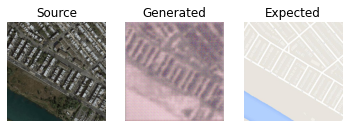

In [ ]:
from keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint

def load_real_samples(filename):
    data = load(filename)
    X1, X2 = data["arr_0"], data["arr_1"]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

def plot_images(src_img, gen_img, tar_img):
    images = vstack((src_img, gen_img, tar_img))
    images = (images + 1) / 2.0
    titles = ["Source", "Generated", "Expected"]
    for i in range(len(images)):
        pyplot.subplot(1, 3, 1 + i)
        pyplot.axis("off")
        pyplot.imshow(images[i])
        pyplot.title(titles[i])
    pyplot.show()

[X1, X2] = load_real_samples("maps_256.npz")
print("Loaded", X1.shape, X2.shape)
# load model
model = load_model("/content/model_000200.h5")
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

gen_image = model.predict(src_image)

plot_images(src_image, gen_image, tar_image)
